每月底計算動能變量，利用其對股票排序分組，透過等權或市值加權的配置形成投資組合，持有一個月後再重新調整投組。

In [1]:
import tejapi
import os
os.environ['TEJAPI_KEY'] = "your key"
os.environ['TEJAPI_BASE'] = "'https://api.tej.com.tw'"
start = '2018-02-01'
end = '2023-12-31'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from zipline.data import bundles
from zipline.sources.TEJ_Api_Data import get_Benchmark_Return
from zipline.pipeline.mixins import SingleInputMixin
from zipline.pipeline.data import TWEquityPricing
from zipline.pipeline.factors import CustomFactor
from zipline.pipeline import Pipeline
from zipline.TQresearch.tej_pipeline import run_pipeline

/usr/local/lib/python3.8/site-packages/zipline/pipeline/data/tejquant.py:3: FutureWarning: `zipline.pipeline.data.tejquant` will be deprecated in a future version, which includes the removal of the `TQDataSet` class. Please migrate to `zipline.pipeline.data.TQFundamentals` for accessing the equivalent classes: `TQData`, `TQDataSet`, `TQAltData`, and `TQAltDataSet`. 
  warnings.warn(


In [2]:
os.environ['ticker'] ='2308 2311 2317 2324 2325 2327 2330 2347 2353 2354 2615 2618 2633 2801 2823 2880 3034 3037 3045 3231 3474 3481 3673 3697 3711 4904 4938 5854 5871 5876 5880 6239 6415 6505 6669 6770 8046 8454 9904 9910 IX0001'
os.environ['mdate'] = start+' '+end
!zipline ingest -b tquant

/usr/local/lib/python3.8/site-packages/zipline/pipeline/data/tejquant.py:3: FutureWarning: `zipline.pipeline.data.tejquant` will be deprecated in a future version, which includes the removal of the `TQDataSet` class. Please migrate to `zipline.pipeline.data.TQFundamentals` for accessing the equivalent classes: `TQData`, `TQDataSet`, `TQAltData`, and `TQAltDataSet`. 
  warnings.warn(
[2024-03-01 05:15:39.699920] INFO: zipline.data.bundles.core: Ingesting tquant.
Merging daily equity files:  [####################################]    
Currently used TEJ API key call quota 27/100000 (0.03%)
Currently used TEJ API key data quota 409139/10000000 (4.09%)
[2024-03-01 05:16:12.289856] INFO: zipline.data.bundles.core: Ingest tquant successfully.


In [3]:
from zipline.pipeline.filters import StaticAssets

class Momentum(CustomFactor):
    inputs = [TWEquityPricing.close]
    window_length = 63    # finding past n days' return
    
    def compute(self, today, assets, out, close):
        
        monthly_return_1 = ((close[21-1]-close[0])/close[0])*100
        monthly_return_2 = ((close[42-1]-close[20])/close[0])*100
        monthly_return_3 = ((close[63-1]-close[41])/close[0])*100

        formation_return = (((monthly_return_1)+(monthly_return_2)+(monthly_return_3))/3).round(5)   # 3 months average return

        out[:] = formation_return

from numpy import average, abs as np_abs
from zipline.pipeline.factors.basic import _ExponentialWeightedFactor, exponential_weights

class WeightedMovingAbsDev(_ExponentialWeightedFactor):

    def compute(self, today, assets, out, data, decay_rate):
        weights = exponential_weights(len(data), decay_rate = 1)

        mean = average(data, axis=0, weights=weights)
        abs_deviation = average(np_abs(data - mean), axis=0, weights=weights)

        out[:] = abs_deviation

In [4]:
start_dt, end_dt = pd.Timestamp(start, tz='utc'), pd.Timestamp(end, tz='utc')
bundle = bundles.load('tquant')
benchmark_asset = bundle.asset_finder.lookup_symbol('IX0001',as_of_date = None)
def make_pipeline():
    mom = Momentum()
    mad_short = WeightedMovingAbsDev(inputs = [TWEquityPricing.close], window_length = 21, decay_rate = 1)
    mad_long = WeightedMovingAbsDev(inputs = [TWEquityPricing.close], window_length = 120, decay_rate = 1)
    curr_price = TWEquityPricing.close.latest
    
    return Pipeline(
        columns = {
        'curr_price': curr_price,
        'Momentum': mom,
        'High': mom.top(8),
        'Low': mom.bottom(8),
        'MAD_short': mad_short,
        'MAD_long': mad_long,
    },
        screen = ~StaticAssets([benchmark_asset])
    )
my_pipeline = run_pipeline(make_pipeline(), start_dt, end_dt)
my_pipeline.tail()

curr_price  Momentum   High  \
2023-12-29 00:00:00+00:00 Equity(32 [6770])        29.7   3.95480  False   
                          Equity(33 [8046])       248.0  -2.31395  False   
                          Equity(34 [8454])       511.0   0.59761  False   
                          Equity(35 [9904])        31.1   2.85049  False   
                          Equity(36 [9910])       174.5  -1.54827  False   

                                               Low  MAD_short   MAD_long  
2023-12-29 00:00:00+00:00 Equity(32 [6770])  False   0.384580   1.085833  
                          Equity(33 [8046])   True   2.424036   9.453125  
                          Equity(34 [8454])  False   5.020408  19.718490  
                          Equity(35 [9904])  False   0.266667   0.878219  
                          Equity(36 [9910])   True   3.027211   6.274553

In [5]:
from zipline.finance import slippage, commission
from zipline.api import *
from zipline.api import set_slippage, set_commission, set_benchmark, attach_pipeline, order, order_target, symbol, pipeline_output, record

def initialize(context):
    set_slippage(slippage.VolumeShareSlippage())
    set_commission(commission.PerShare(cost = 0.001425 + 0.003 / 2))
    attach_pipeline(make_pipeline(), 'mystrats')
    set_benchmark(symbol('IX0001'))
    context.day_count = 0
    context.high_list = []
    context.low_list = []
    context.history_high = []
    context.history_low = []

In [6]:
def handle_data(context, data):
    out_dir = pipeline_output('mystrats')
    
    context.day_count += 1
    if context.day_count > 63:
        context.day_count = -20
    if context.day_count == 1:
        for j in context.high_list:
            context.history_high.append(j)
        for y in context.low_list:
            context.history_low.append(y)
        # reset the recorded stocks
        context.high_list = []
        context.low_list = []


    for i in out_dir.index:
        sym = i.symbol
        Momentum = out_dir.loc[i, "Momentum"]
        High = out_dir.loc[i, 'High']
        Low = out_dir.loc[i, "Low"]
        MAD_short = out_dir.loc[i, 'MAD_short']
        MAD_long = out_dir.loc[i, 'MAD_long']
        curr_price = out_dir.loc[i, 'curr_price']
        
        cash_position = context.portfolio.cash
        stock_position = context.portfolio.positions[i].amount

        buy, sell = False, False
        
        record(
           **{
                f'price_{sym}':curr_price,
                f'Momentum_{sym}':Momentum,
                f'High_{sym}':High,
                f'Low_{sym}':Low,
                f'MAD_short_{sym}': MAD_short,
                f'MAD_long_{sym}': MAD_long,
                f'buy_{buy}':buy,
                f'sell_{sym}':sell
            }
        )

# record month -> record 3 months' momentum
        if (context.day_count == 1) and (High == True) and (len(context.high_list) < 45):
            context.high_list.append(i)
        if (context.day_count == 1) and (Low == True) and (len(context.low_list) < 45):
            context.low_list.append(i)
        
# trade month (Long, Short) -> first day in trade month, context.high_list and context.low_list have values
        if (context.day_count == 0) and (i in context.high_list) and (cash_position > curr_price * 2000):
            order(i, 2000)
            buy = True
            record(buy = buy)
            context.high_list = [x for x in context.high_list if x != i]
        elif (context.day_count == 0) and (i in context.low_list) and (cash_position >= 0):
            order(i, -2000)
            buy = True
            record(buy = buy)
            context.low_list = [x for x in context.low_list if x != i]
            
# Exiting the position (clearing the position from the previous trading month on the 21st day of the recording month) ->
# MAD_short > MAD_long or MAD_short > MAD_long        
        if (21 <= context.day_count <= 63) and (MAD_short > MAD_long) and (stock_position > 0) and (i in context.history_high):
            order_target(i, 0)
            sell = True
            record(sell = sell)
            context.history_high = [x for x in context.history_high if x != i]
        elif (21 <= context.day_count <= 63) and (MAD_short < MAD_long) and (i in context.history_low):
            order_target(i, 0)
            sell = True
            record(sell = sell)
            context.history_low = [x for x in context.history_low if x != i]

In [7]:
def analyze(context, perf):
    pass

In [8]:
from zipline import run_algorithm
results = run_algorithm(
    start = start_dt,
    end = end_dt,
    initialize=initialize,
    bundle='tquant',
    analyze=analyze,
    capital_base=1e7,
    handle_data = handle_data
)

In [9]:
results

,period_open,period_close,longs_count,shorts_count,ending_value,long_value,short_value,starting_cash,long_exposure,ending_cash,...,MAD_long_6669,sell_6669,sell,price_6770,Momentum_6770,High_6770,Low_6770,MAD_short_6770,MAD_long_6770,sell_6770
2018-02-01 13:30:00+08:00,2018-02-01 09:01:00+08:00,2018-02-01 13:30:00+08:00,0,0,0.0,0.0,0.0,1.000000e+07,0.0,1.000000e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-02 13:30:00+08:00,2018-02-02 09:01:00+08:00,2018-02-02 13:30:00+08:00,0,0,0.0,0.0,0.0,1.000000e+07,0.0,1.000000e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-05 13:30:00+08:00,2018-02-05 09:01:00+08:00,2018-02-05 13:30:00+08:00,0,0,0.0,0.0,0.0,1.000000e+07,0.0,1.000000e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-06 13:30:00+08:00,2018-02-06 09:01:00+08:00,2018-02-06 13:30:00+08:00,0,0,0.0,0.0,0.0,1.000000e+07,0.0,1.000000e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-07 13:30:00+08:00,2018-02-07 09:01:00+08:00,2018-02-07 13:30:00+08:00,0,0,0.0,0.0,0.0,1.000000e+07,0.0,1.000000e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25 13:30:00+08:00,2023-12-25 09:01:00+08:00,2023-12-25 13:30:00+08:00,11,17,20613716.6,31042553.2,-10428836.6,3.987693e+06,31042553.2,3.987693e+06,...,127.458333,False,True,29.15,2.78810,False,False,0.378912,1.131743,False
2023-12-26 13:30:00+08:00,2023-12-26 09:01:00+08:00,2023-12-26 13:30:00+08:00,11,17,20700126.3,31242738.7,-10542612.4,3.987693e+06,31242738.7,3.987693e+06,...,127.416667,False,True,28.90,1.95360,False,False,0.389796,1.115646,False
2023-12-27 13:30:00+08:00,2023-12-27 09:01:00+08:00,2023-12-27 13:30:00+08:00,11,17,20398513.3,31130863.3,-10732350.0,3.987693e+06,31130863.3,3.987693e+06,...,127.201389,False,True,29.25,3.25203,False,False,0.391383,1.096667,False
2023-12-28 13:30:00+08:00,2023-12-28 09:01:00+08:00,2023-12-28 13:30:00+08:00,11,17,20021986.7,31026609.1,-11004622.4,3.987693e+06,31026609.1,3.987693e+06,...,126.356250,False,True,29.80,4.29293,False,False,0.391383,1.089583,False


<AxesSubplot:>

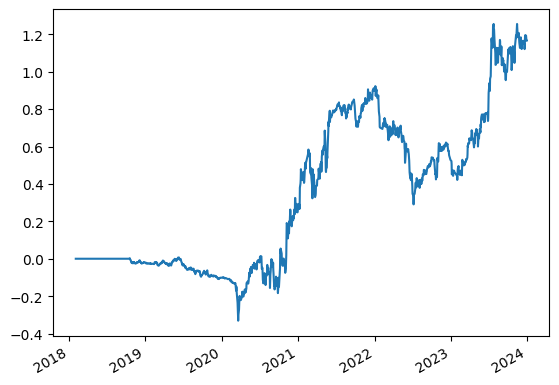

In [10]:
results.returns.cumsum().plot()

<AxesSubplot:>

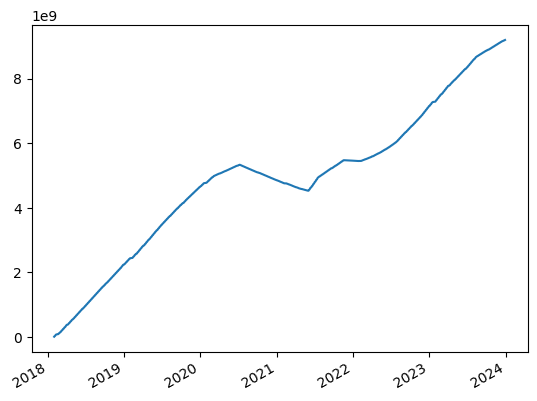

In [11]:
results.starting_cash.cumsum().plot()

Start date,2018-02-01
End date,2023-12-29
Total months,68
,Backtest
Annual return,16.563%
Cumulative returns,140.225%
Annual volatility,31.915%
Sharpe ratio,0.64
Calmar ratio,0.34
Stability,0.62
Max drawdown,-48.423%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,48.42,2022-01-04,2022-07-06,2023-07-11,365
1,29.03,2019-06-10,2020-03-19,2020-11-05,347
2,27.49,2023-07-24,2023-09-20,NaT,NaN
3,23.83,2021-02-18,2021-03-22,2021-05-06,52
4,20.55,2021-05-07,2021-05-13,2021-05-25,13


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS


Stress Events,mean,min,max
New Normal,0.08%,-9.79%,11.08%


Top 10 long positions of all time,max
sid,
6669,106.36%
6415,84.42%
8454,34.56%
8046,25.03%
2327,18.13%
9910,10.77%
3034,8.96%
5871,6.83%
3037,5.88%


Top 10 short positions of all time,max
sid,
8454,-29.26%
6415,-20.59%
3034,-19.71%
2330,-7.70%
3673,-4.48%
2308,-4.36%
3711,-3.82%
5871,-3.28%
4938,-3.25%


Top 10 positions of all time,max
sid,
6669,106.36%
6415,84.42%
8454,34.56%
8046,25.03%
3034,19.71%
2327,18.13%
9910,10.77%
2330,7.70%
5871,6.83%


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei


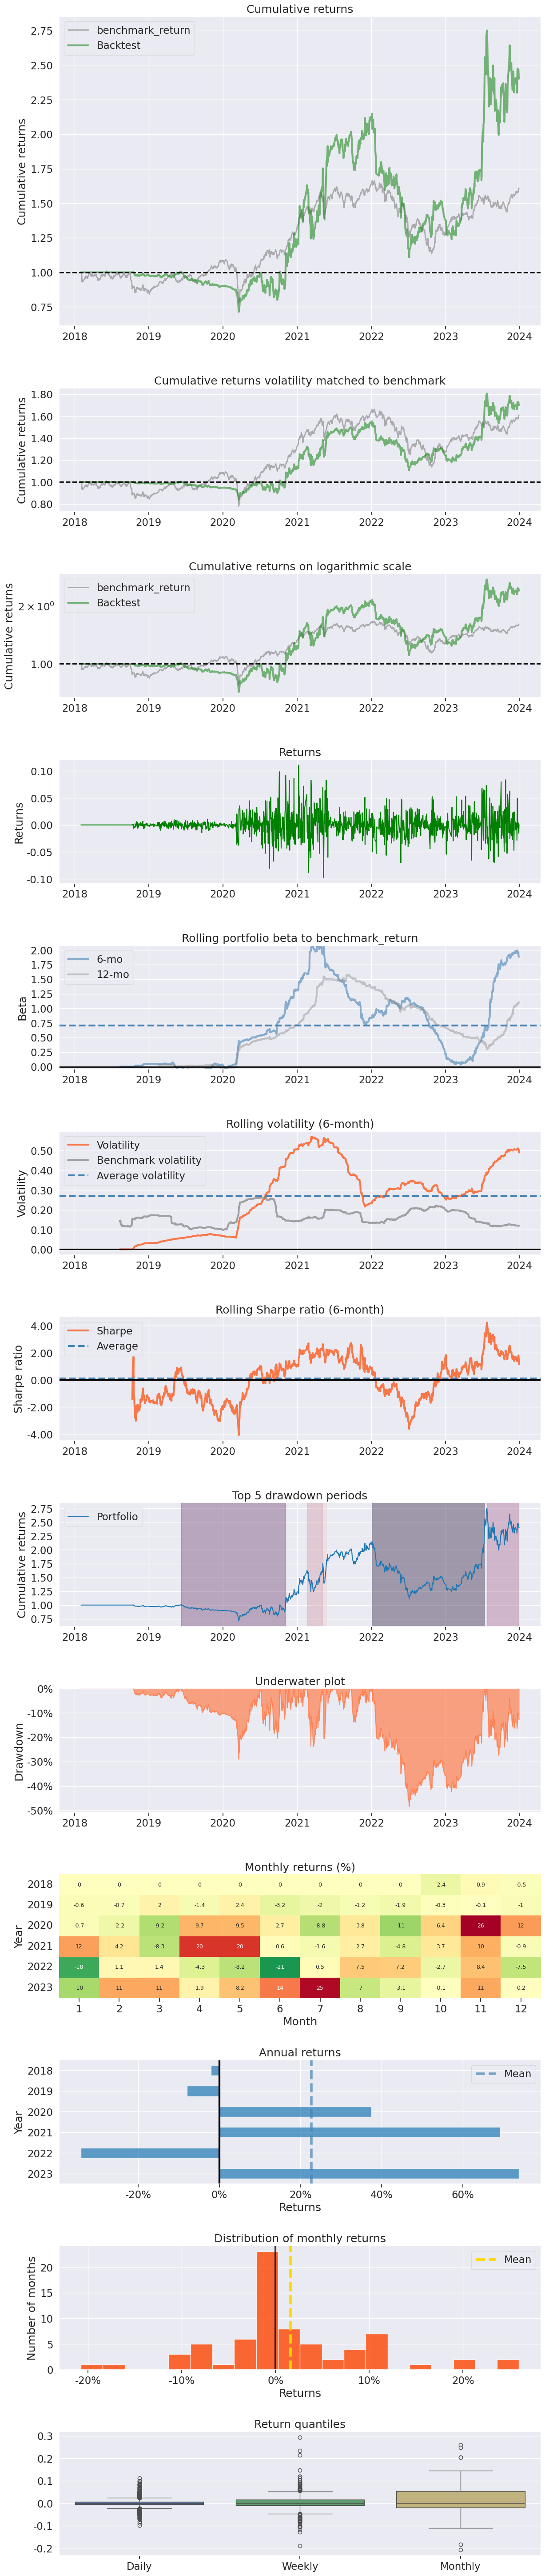

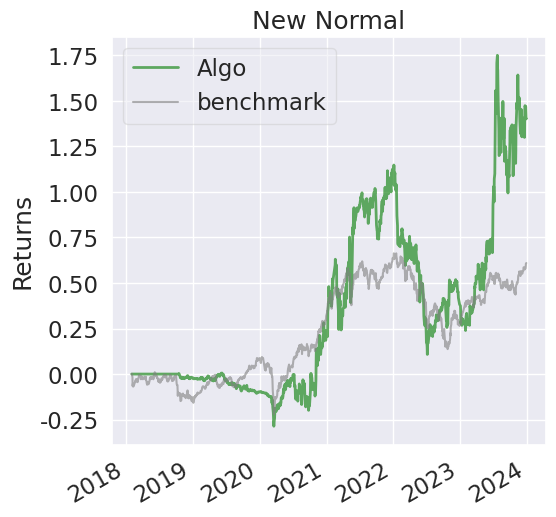

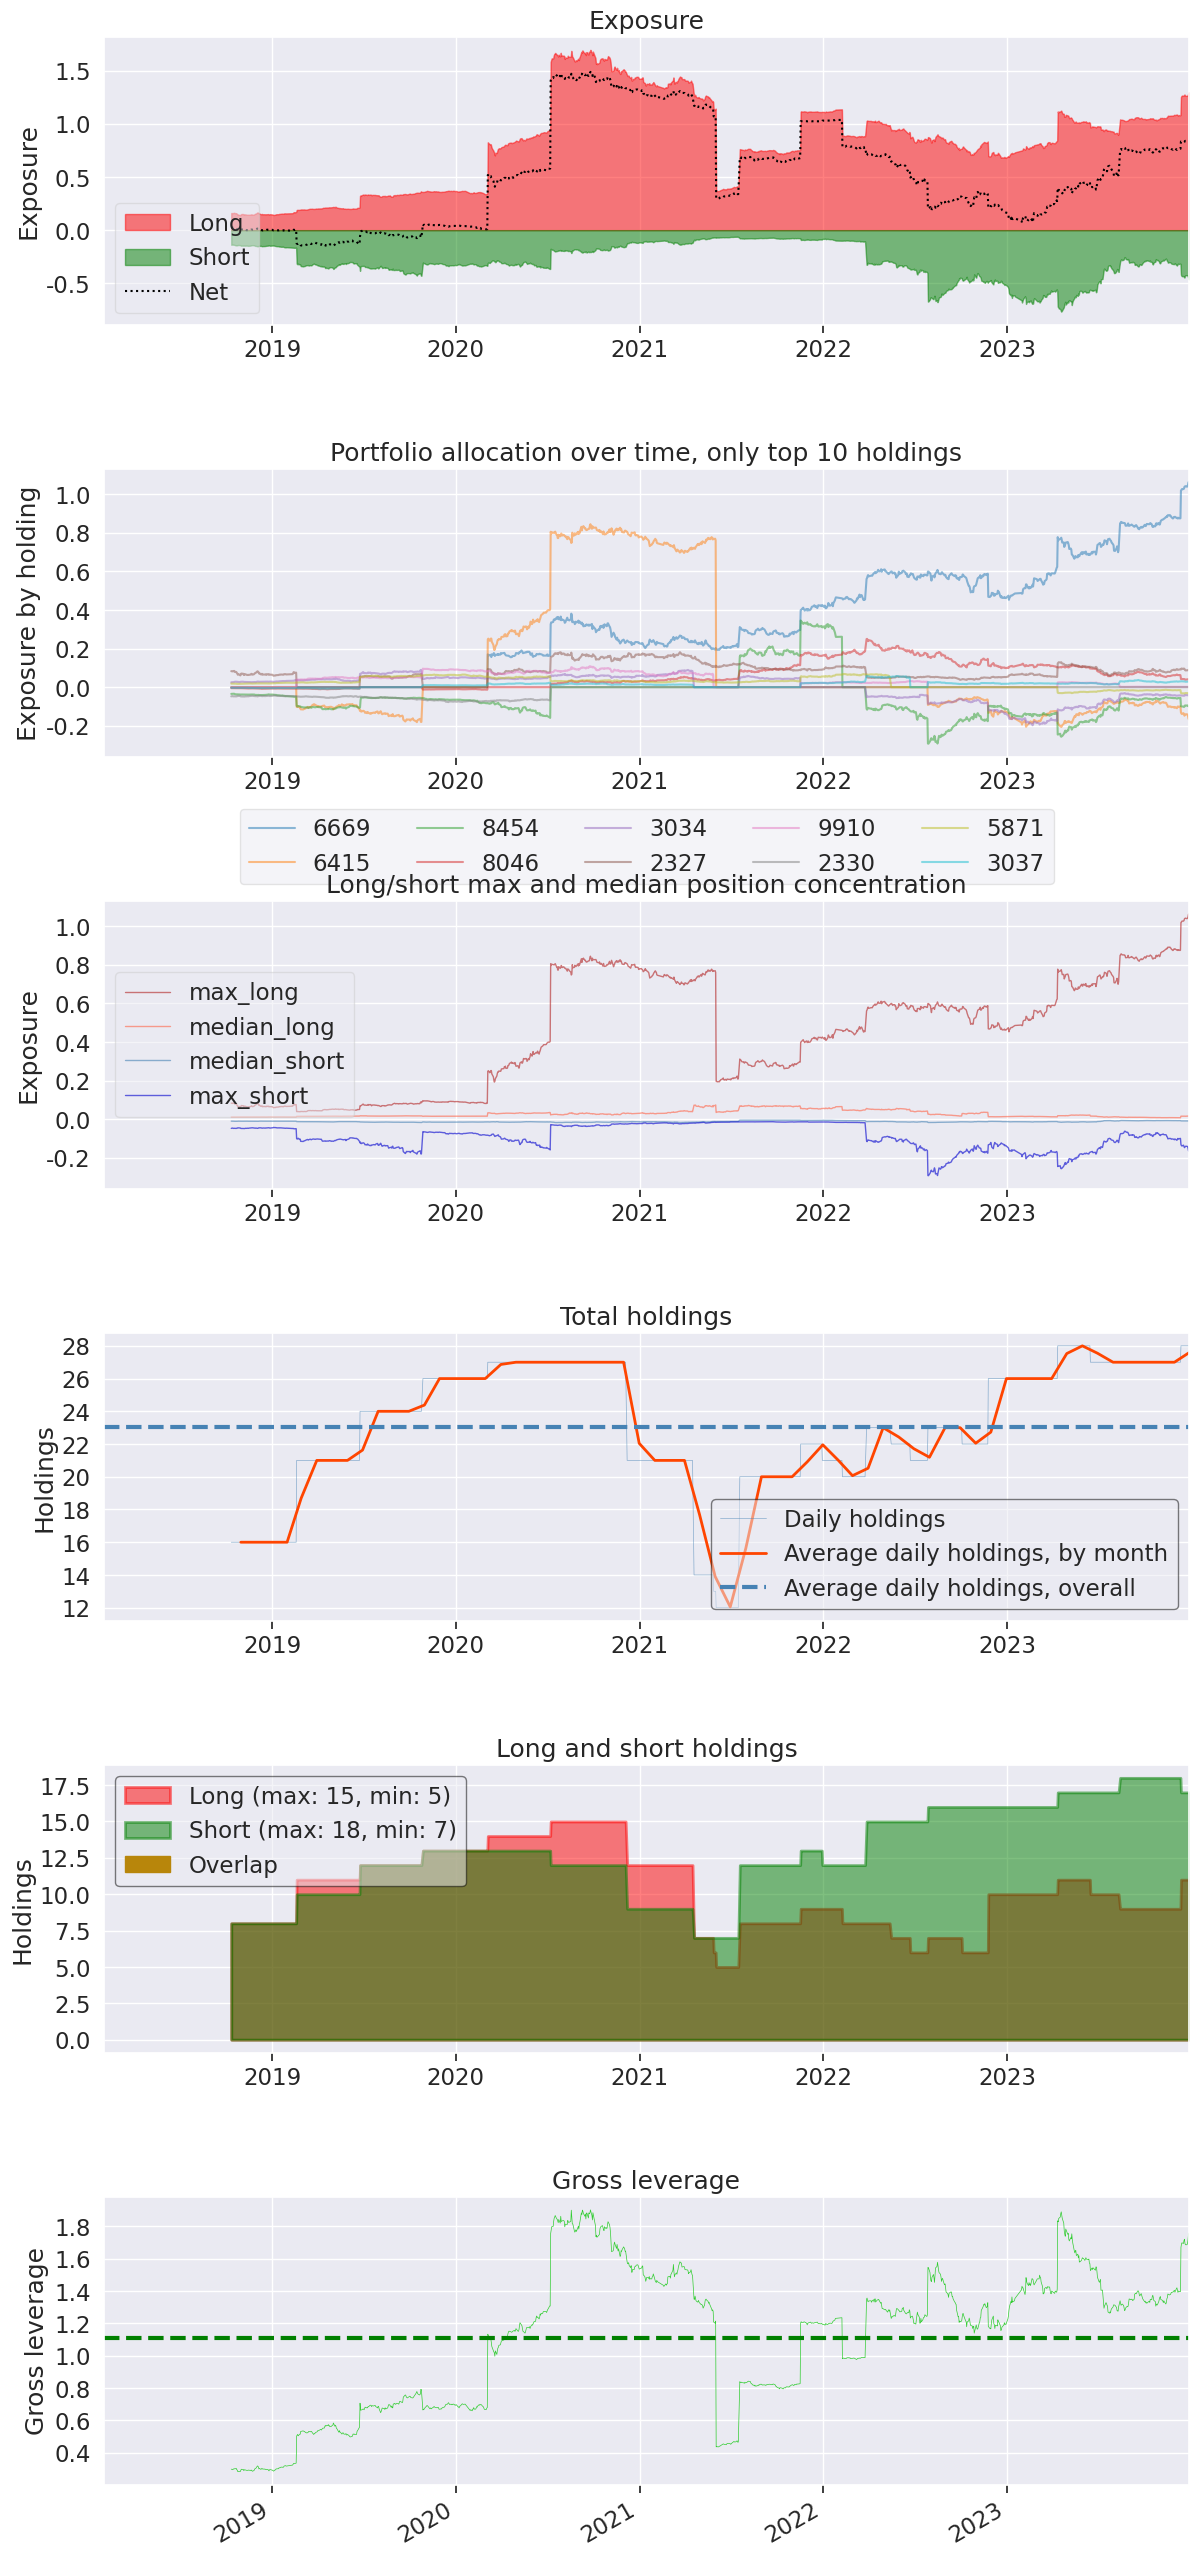

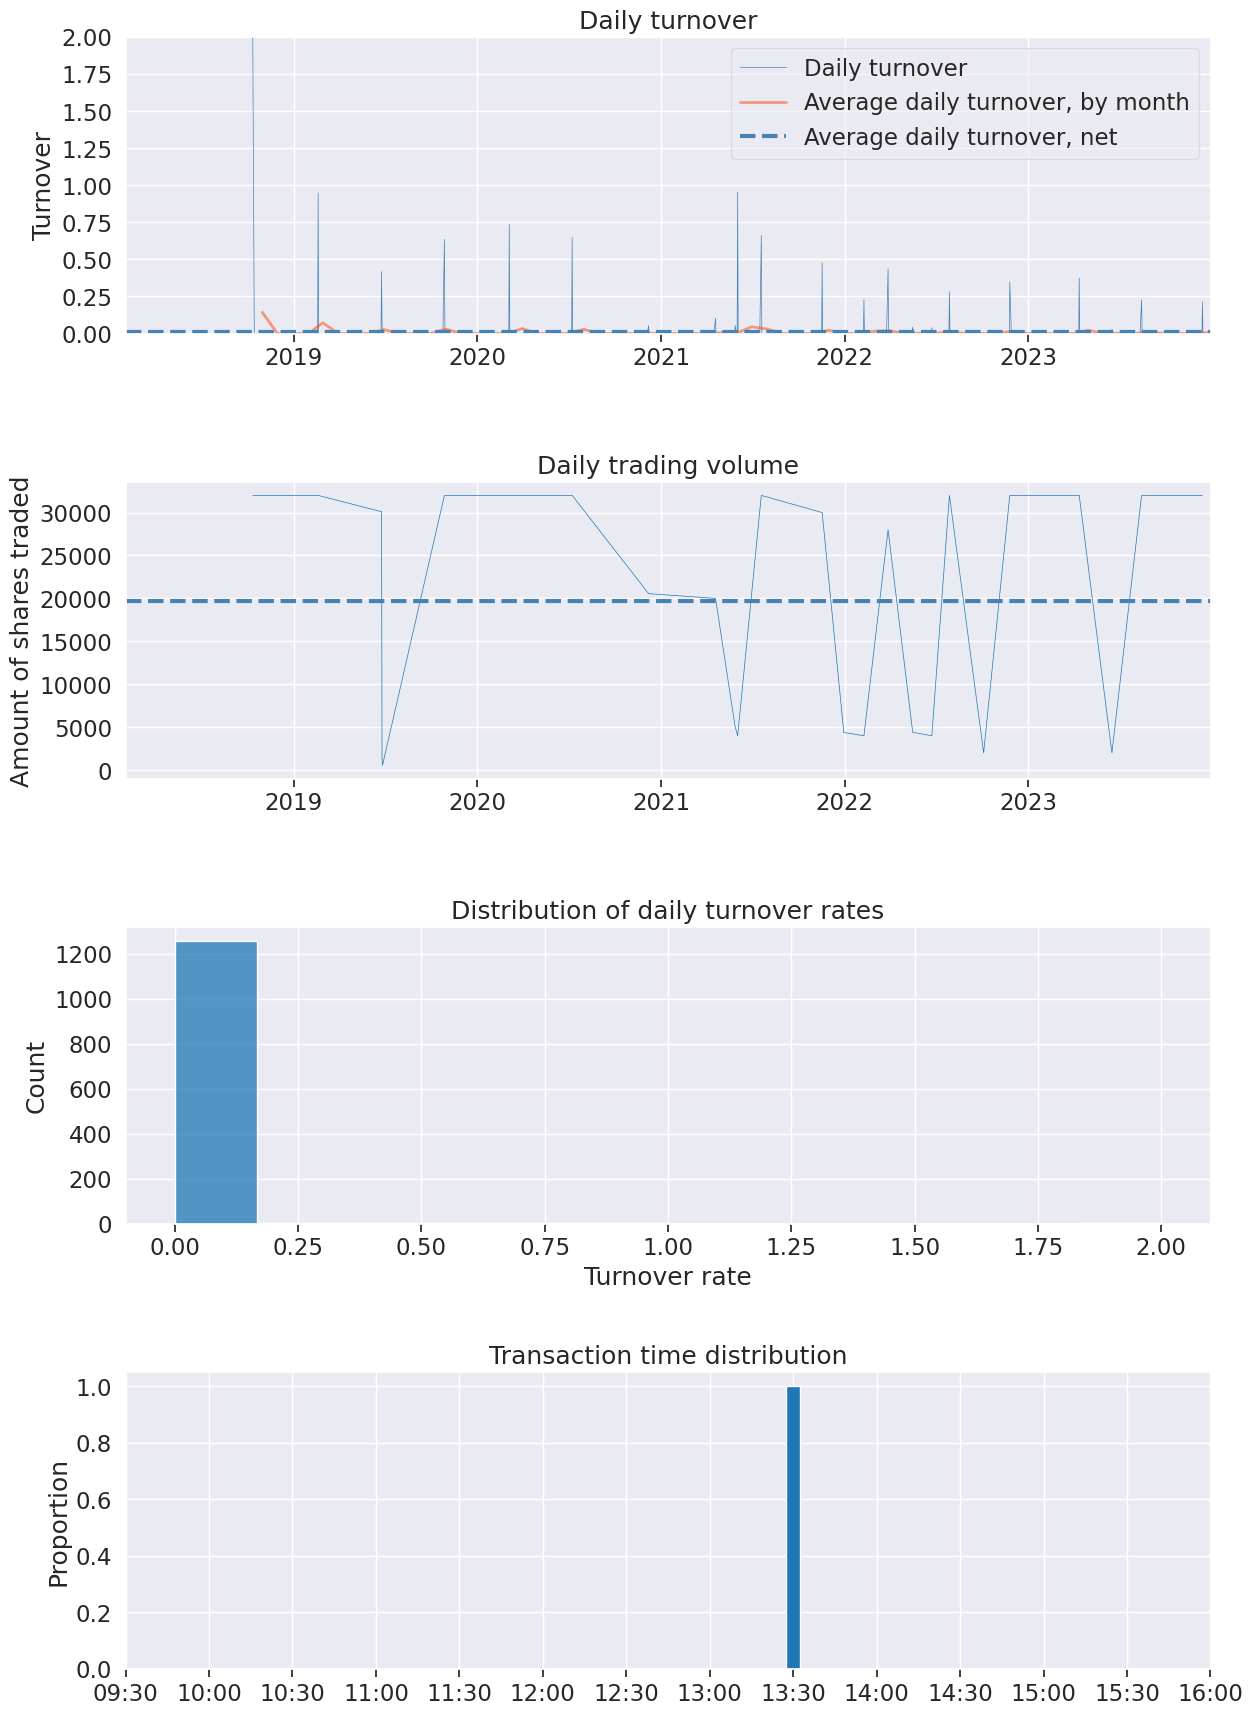

In [12]:
import pyfolio as pf
from pyfolio.utils import extract_rets_pos_txn_from_zipline

returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
benchmark_rets = results.benchmark_return

# Creating a Full Tear Sheet
pf.create_full_tear_sheet(returns, positions = positions, transactions = transactions,
                          benchmark_rets = benchmark_rets,
                          round_trips=False)